In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISIC/train/'
# validation_dir = 'data-ISIC/validation'
test_dir = 'data-ISIC/test'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISIC/train/ 0
data-ISIC/train/AKIEC 3856
data-ISIC/train/BCC 4773
data-ISIC/train/BKL 3275
data-ISIC/train/DF 4152
data-ISIC/train/MEL 3308
data-ISIC/train/NV 4975
data-ISIC/train/VASC 3488
******************************
data-ISIC/test 0
data-ISIC/test\AKIEC 1552
data-ISIC/test\BCC 1692
data-ISIC/test\BKL 1479
data-ISIC/test\DF 1632
data-ISIC/test\MEL 1664
data-ISIC/test\NV 1730
data-ISIC/test\VASC 1484


In [5]:
output_classes = 7
batch_size = 4
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

top_model_weights_path = 'bottleneck_fc_model.h5'

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
# nb_validation_samples = sum([len(files) for r, d, files in os.walk(validation_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])

In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_datagen = ImageDataGenerator(rescale=1. / 255)

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

num_classes = len(train_generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

In [9]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    # print(model.summary())

    bottleneck_features_train = model.predict_generator(train_generator, predict_size_train)
    bottleneck_features_validation = model.predict_generator(validation_generator, predict_size_validation)
    
    np.save('bottleneck_features_train.npy', bottleneck_features_train)
    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [10]:
save_bottlebeck_features()

In [11]:
def train_top_model():

    train_data = np.load('bottleneck_features_train.npy')
    validation_data = np.load('bottleneck_features_validation.npy')

    train_labels = train_generator.classes
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    validation_labels = validation_generator.classes
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)
    

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, 
        batch_size= batch_size, 
        verbose=1)
    
    print ("*" *50)
    print("Validation Accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("Validation Loss: {}".format(eval_loss))
    

    plt.figure(1)

    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Train on 27827 samples, validate on 11233 samples
Epoch 1/50
27827/27827 [==============================] - 49s 2ms/step - loss: 1.4820 - acc: 0.4309 - val_loss: 1.2506 - val_acc: 0.5281
Epoch 2/50
27827/27827 [==============================] - 48s 2ms/step - loss: 1.1399 - acc: 0.5710 - val_loss: 1.0801 - val_acc: 0.5912oss: 1.1462 - acc:  - ETA: 2s - loss: 1.1463 - acc:  - ETA: 2s - loss: 1.14 - ETA: 1s - l
Epoch 3/50
27827/27827 [==============================] - 48s 2ms/step - loss: 0.9647 - acc: 0.6407 - val_loss: 1.0546 - val_acc: 0.5978
Epoch 4/50
27827/27827 [==============================] - 48s 2ms/step - loss: 0.8574 - acc: 0.6800 - val_loss: 0.9640 - val_acc: 0.6564 loss: 0.8571 - acc - ETA: 0s - loss: 0.8575 - acc: 0.679
Epoch 5/50
27827/27827 [==============================] - 48s 2ms/step - loss: 0.7677 - acc: 0.7189 - val_loss: 0.9994 - val_acc: 0.6594
Epoch 6/50
27827/27827 [==============================] - 48s 2ms/step - loss: 0.7081 - acc: 0.7367 - val_loss: 0.9542 

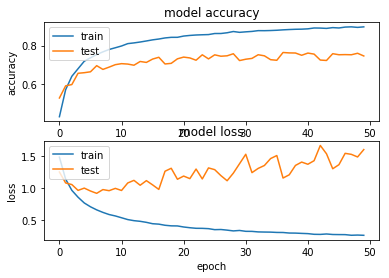

In [12]:
train_top_model()